# Prose Kaleidoscopes - RNN Experiment

In [1]:
# Imports

from collections import Counter

import copy
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import torch.nn as nn

from torch_rnn_classifier import TorchRNNClassifier
from torch_tree_nn import TorchTreeNN
import sst
import model_utils

# If Jupyter complains that torch is an unknown module, try:
# conda install pytorch torchvision -c pytorch
import torch

# Transformers
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig
from transformers import BertModel

%matplotlib inline

# Own files
import dataset_io


# These params should never change
NUM_EPOCHS = 4 
SEED = 42
BATCH_SIZE = 8
LEARNING_RATE = 4e-5
NUM_WARMUP_STEPS = 100
MAX_SEQ_LEN = 512

# Constants
DATASET_TYPE_IMDB = "imdb"
DATASET_TYPE_AMAZON = "amazon"
DATASET_TYPE_SST2 = "sst2"

In [2]:
# Retrieve GloVe pretrained vectors.

GLOVE_DIR = "glove"
GLOVE_ZIP_FILE = "{0}/glove.6B.zip".format(GLOVE_DIR)
GLOVE_PATH = "{0}/glove.6B.50d.txt".format(GLOVE_DIR)
GLOVE_FILE_EXISTS = os.path.exists(GLOVE_PATH)

if not os.path.exists(GLOVE_DIR):
    GLOVE_FILE_EXISTS = False
    os.mkdir(GLOVE_DIR)

if not GLOVE_FILE_EXISTS:
    # Works on both Mac and Linux. If you are on Windows,
    # please download the zip file manually.
    if not os.path.exists(GLOVE_ZIP_FILE):
        !cd {GLOVE_DIR}; curl -LO http://nlp.stanford.edu/data/glove.6B.zip
    !cd {GLOVE_DIR}; unzip glove.6B.zip


GLOVE_LOOKUP = model_utils.glove2dict(GLOVE_PATH)

In [3]:
def normalize_list_labels(lst, dataset_type):
    if dataset_type == DATASET_TYPE_IMDB:
        # Labels are either "positive" or "negative"
        return [0 if v == "negative" else 1 for v in lst]
    if dataset_type == DATASET_TYPE_AMAZON:
        # Labels are in the range [1, 5]
        return [(v - 1) * (1.0 / 5) for v in lst]
    # SST-2 are 0 (negative) or 1 (positive).
    return lst

def normalize_labels(df, label_field):
    labels = getattr(df, label_field).to_numpy()
    # Fix IMDB labels.
    is_imdb = len(set(labels)) == 2 and not str(labels[0]).isdigit() and "positive" in labels and "negative" in labels
    # Fix Amazon labels.
    is_amazon = len(set(labels)) == 5 and min(set(labels)) == 1 and max(set(labels)) == 5
    if is_imdb:
        return pd.get_dummies(labels)["positive"]  # 0 is neg, 1 is pos
    if is_amazon:
        return labels - 1
    return labels

def vsm_phi(text, lookup, np_func=np.mean):
    allvecs = np.array([lookup[w] for w in text.split() if w in lookup])
    if len(allvecs) == 0:
        dim = len(next(iter(lookup.values())))
        feats = np.zeros(dim)
    else:
        feats = np_func(allvecs, axis=0)
    return feats

def glove_phi(text, np_func=np.mean):
    return vsm_phi(text, glove_lookup, np_func=np_func)

def simple_leaves_phi(text):
    return text.split()

#  {'embed_dim': 50, 'eta': 0.005, 'hidden_dim': 100}
def fit_rnn_classifier(X, y):
    #print(y)
    basemod = TorchRNNClassifier(
        GLOVE_VOCAB,
        embedding=GLOVE_EMBEDDING,
        batch_size=25,
        embed_dim=50,
        hidden_dim=100,
        bidirectional=True,
        early_stopping=True, 
        eta=0.005)
    basemod.fit(X, y)
    return basemod

In [4]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def get_roc_metrics(probs, y_true, num_classes, dataset_type):
    preds = np.array(probs)
    if dataset_type != DATASET_TYPE_AMAZON:
        fpr, tpr, threshold = roc_curve(y_true, preds)
        roc_auc = auc(fpr, tpr)
        
        # Get accuracy over the test set
        y_pred = np.where(preds >= 1.0 / num_classes, 1, 0)
        accuracy = accuracy_score(y_true, y_pred)
        return { 
            'fpr' : fpr, 
            'tpr' : tpr, 
            'roc_auc' : roc_auc, 
            'accuracy' : accuracy
        }
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Force any empty categories to be present
    cat_preds = pd.DataFrame(preds)
    cat_preds = cat_preds.astype(pd.CategoricalDtype(categories=list([round(i / num_classes, 1) for i in range(NUM_CLASSES)])))
    y_true = pd.get_dummies(y_true).to_numpy()
    preds = pd.get_dummies(cat_preds).to_numpy()

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], preds[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), preds.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(num_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= NUM_CLASSES
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    y_pred = np.where(preds >= 1.0 / num_classes, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    metrics = {'accuracy' : accuracy}
    for k in fpr.keys():
        metrics["fpr_{0}".format(k)] = fpr[k]
        metrics["tpr_{0}".format(k)] = tpr[k]
        metrics["roc_auc_{0}".format(k)] = roc_auc[k]
    return metrics
    
def evaluate_roc_twoclass(probs, y_true, num_classes, dataset_type):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    fpr, tpr, roc_auc, accuracy = list(get_roc_metrics(probs, y_true, num_classes, dataset_type).values())
    print(f'AUC: {roc_auc:.4f}')
    print(f'Accuracy: {accuracy*100:.4f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
def evaluate_roc_multiclass(probs, y_true, num_classes, dataset_type):
    metrics = get_roc_metrics(probs, y_true, num_classes, dataset_type)
    ks = ["macro", "micro"] + [i for i in range(NUM_CLASSES)]
    fpr = { k : metrics["fpr_{0}".format(k)] for k in ks }
    tpr = { k : metrics["tpr_{0}".format(k)] for k in ks }
    roc_auc = { k : metrics["roc_auc_{0}".format(k)] for k in ks }
    accuracy = metrics['accuracy']
    
    print(f'AUC: {0}', roc_auc)
    print(f'Accuracy: {accuracy*100:.4f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr["micro"], tpr["micro"], 'b', label = 'Micro-avg AUC = %0.2f' % roc_auc["micro"], color = 'navy')
    plt.plot(fpr["macro"], tpr["macro"], 'b', label = 'Macro-avg AUC = %0.2f' % roc_auc["macro"], color = 'darkviolet')
    colors = ['orange', 'forestgreen', 'cornflowerblue', 'darkgoldenrod', 'tomato', 'dodgerblue']
    lw=2
    for i, color in zip(range(NUM_CLASSES), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw, label='AUC of class {0} = {1:0.2f})'.format(i, roc_auc[i]))
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

def evaluate_roc(probs, y_true, num_classes, dataset_type):
    if dataset_type == DATASET_TYPE_AMAZON:
        evaluate_roc_multiclass(probs, y_true, num_classes, dataset_type)
    else:
        evaluate_roc_twoclass(probs, y_true, num_classes, dataset_type)

In [5]:
# Execution and Metrics
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix
from sklearn.metrics import accuracy_score, balanced_accuracy_score, cohen_kappa_score, roc_auc_score

def get_pred(value, num_classes):
    interval = 1.0 / num_classes
    for i in range(0, num_classes):
        if value < (i + 1) * interval:
            return i
    return num_classes - 1

def run_and_eval(train, test, text_field, label_field, test_labels, num_classes, dataset_type):
    # Evaluate on test set
    rnn_experiment = sst.experiment(
        train,
        simple_leaves_phi, 
        fit_rnn_classifier,
        assess_dataframes=[test], 
        vectorize=False,
        text_field=text_field,
        label_field=label_field)
    
    test_probs = rnn_experiment['predictions'][0]
    test_probs_norm = normalize_list_labels(test_probs, dataset_type)

    # Evaluate the classifier
    print("Test Set")
    evaluate_roc(test_probs_norm, test_labels, num_classes, dataset_type)
    
    test_preds = np.array([get_pred(p, num_classes) for p in test_probs_norm])
    return copy.deepcopy(test_preds)

def get_metrics_report(train, test, test_preds, test_labels, 
                       train_path, test_path, label_field,
                       dataset_type, expr_type, num_samples, run_id, report_destpath=None):
    metrics_report = classification_report(_TEST_LABELS, test_preds, output_dict=True, digits=4)
    run_report = { 
        "dataset" : dataset_type, 
        "expr" : expr_type,
        "num_samples" : num_samples, 
        "run_id" : run_id
    }
    metrics_report.update(run_report)

    report_str = "### RNN | Dataset: {0}, Expr: {1}, N{2}, R{3}\n".format(
        dataset_type, expr_type, num_samples, run_id)
    report_str += "```\n"
    report_str += "Train: {0}\nTest: {1}\n-------------------------------\n".format(
        train_path, test_path)
    
    if dataset_type != DATASET_TYPE_AMAZON:
        report_str += "AUC: {0:.4f}\n".format(roc_auc_score(test_labels, test_preds, multi_class='ovr'))
    report_str += "Accuracy:\t{0:.4f}\t\tBalanced Acc: {1:.4f}\n".format(
        accuracy_score(test_preds, test_labels), balanced_accuracy_score(test_preds, test_labels))
    report_str += "Kappa:\t{0}\n".format(cohen_kappa_score(test_preds, test_labels))
    report_str += classification_report(test_labels, test_preds, digits=4)
    report_str += "\n"
    report_str += "Train distribution:\t{0}\nTest distribution:\t{1}\n".format(
        getattr(train, label_field).value_counts().to_dict(),
        getattr(test, label_field).value_counts().to_dict())
    labels = [0, 1] if dataset_type != DATASET_TYPE_AMAZON else [0, 1,2 , 3, 4]
    cm = multilabel_confusion_matrix(test_labels, test_preds, labels=labels)
    report_str += "Confusion matrix:\n\t{0}".format(
        "\n\t".join(["Label {0}: TP {1}, FP {2}, TN {3}, FN {4}".format(
            labels[i], cm[i][1][1], cm[i][0][1], cm[i][0][0], cm[i][1][0]) for i in range(len(cm))]))
    report_str += "\n```\n\n"
    
    if report_destpath is not None:
        file_obj = open(report_destpath, 'a')
        file_obj.write(report_str)
        file_obj.close()


In [6]:
def get_train_path(expr_type, num_samples, run_id, dataset_filename, file_ext):
    return "expr_data/{0}/{1}/r{2}/expr_{0}_n{1}_r{2}_{3}.{4}".format(
        expr_type, num_samples, run_id, dataset_filename, file_ext)

# RNN Processing
def proc_rnn_x(df):
    return list(getattr(df, TEXT_FIELD).apply(lambda s : s.split())) 

def load_glove(train):
    x_train = proc_rnn_x(train)
    train_vocab = model_utils.get_vocab(x_train, mincount=2)
    glove_embedding, glove_vocab = model_utils.create_pretrained_embedding(GLOVE_LOOKUP, train_vocab)
    return glove_embedding, glove_vocab

#"""
# SST-2
DATASET_FILENAME = "sst2_train"
DATASET_TYPE = "sst2"
FILE_EXT = "tsv"
LABEL_FIELD = "label"
TEXT_FIELD = "sentence"
TEST_PATH = "expr_data/devtest/{0}_test.{1}".format(DATASET_TYPE, FILE_EXT)
#"""

"""
# IMDB
DATASET_FILENAME = "imdb"
DATASET_TYPE = "imdb"
FILE_EXT = "csv"
LABEL_FIELD = "sentiment"
TEXT_FIELD = "review"
TEST_PATH = "expr_data/devtest/{0}_test.{1}".format(DATASET_FILENAME, FILE_EXT)
"""

"""
# Amazon Reviews
DATASET_FILENAME = "amazon_reviews_digital_music"
DATASET_TYPE = "amazon"
FILE_EXT = "json"
LABEL_FIELD = "overall"
TEXT_FIELD = "reviewText"
OUTPUT_RESLTS_PATH = "results/amazon_results.json"
TEST_PATH = "expr_data/devtest/{0}_test.{1}".format(DATASET_FILENAME, FILE_EXT)
"""


TEST = dataset_io.to_df(TEST_PATH)
_TEST_LABELS = normalize_labels(TEST, LABEL_FIELD)
NUM_CLASSES = len(set(getattr(TEST, LABEL_FIELD)))

### Experiment Changes Start Here

In [7]:
# NUM_SAMPLES can be 10 or 50.
NUM_SAMPLES = 10

RESULTS_DIR = "results"
if not os.path.exists(RESULTS_DIR):
    os.mkdir(RESULTS_DIR)

REPORT_RESULTS_PATH = "{0}/{1}_{2}_rnn_report.md".format(RESULTS_DIR, DATASET_TYPE, NUM_SAMPLES)

if not os.path.exists(REPORT_RESULTS_PATH):
    open(REPORT_RESULTS_PATH, 'a').close()
    print("Metrics report will be written to {0}".format(REPORT_RESULTS_PATH))
else:
    print("Metrics report will be appended to {0}".format(REPORT_RESULTS_PATH))

Metrics report will be written to results/sst2_10_rnn_report.md


Finished epoch 2 of 1000; error is 0.6066947579383854



Running sst2 experiment on orig, N10, run# 0


Stopping after epoch 12. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.2683313190937042

              precision    recall  f1-score   support

           0      0.000     0.000     0.000       912
           1      0.499     1.000     0.666       909

    accuracy                          0.499      1821
   macro avg      0.250     0.500     0.333      1821
weighted avg      0.249     0.499     0.332      1821

Test Set
AUC: 0.5000
Accuracy: 49.9176%


/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


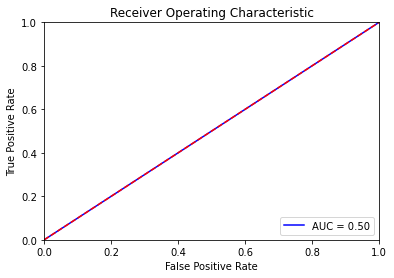

/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/



Running sst2 experiment on orig, N10, run# 1


Stopping after epoch 12. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.3005124628543854

              precision    recall  f1-score   support

           0      0.000     0.000     0.000       912
           1      0.499     1.000     0.666       909

    accuracy                          0.499      1821
   macro avg      0.250     0.500     0.333      1821
weighted avg      0.249     0.499     0.332      1821

Test Set
AUC: 0.5000
Accuracy: 49.9176%


/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


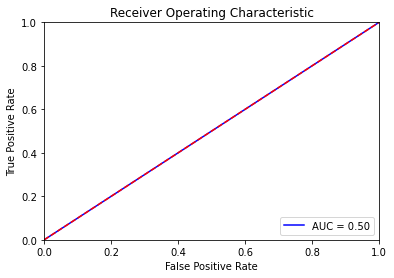

/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/



Running sst2 experiment on orig, N10, run# 2


Stopping after epoch 12. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.19801431894302368

              precision    recall  f1-score   support

           0      0.000     0.000     0.000       912
           1      0.499     1.000     0.666       909

    accuracy                          0.499      1821
   macro avg      0.250     0.500     0.333      1821
weighted avg      0.249     0.499     0.332      1821

Test Set
AUC: 0.5000
Accuracy: 49.9176%


/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


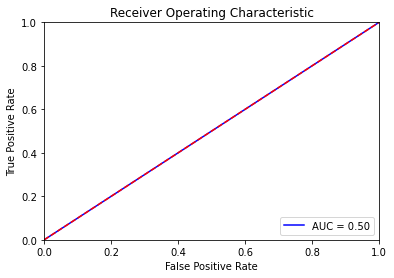

/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/



Running sst2 experiment on orig, N10, run# 3


Stopping after epoch 12. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.0

              precision    recall  f1-score   support

           0      0.000     0.000     0.000       912
           1      0.499     1.000     0.666       909

    accuracy                          0.499      1821
   macro avg      0.250     0.500     0.333      1821
weighted avg      0.249     0.499     0.332      1821

Test Set
AUC: 0.5000
Accuracy: 49.9176%


/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


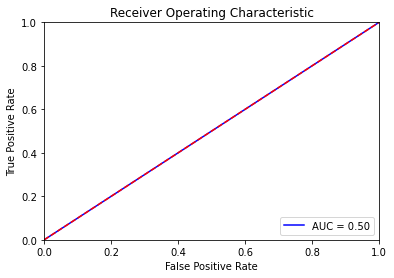

/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/



Running sst2 experiment on orig, N10, run# 4


Stopping after epoch 12. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.27437102794647217

              precision    recall  f1-score   support

           0      0.000     0.000     0.000       912
           1      0.498     0.994     0.663       909

    accuracy                          0.496      1821
   macro avg      0.249     0.497     0.332      1821
weighted avg      0.248     0.496     0.331      1821

Test Set
AUC: 0.4972
Accuracy: 49.6431%


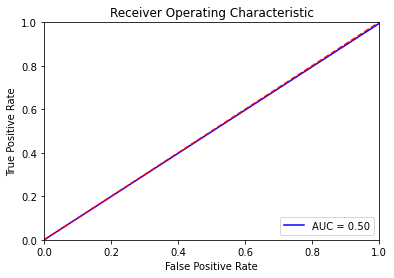

Finished epoch 2 of 1000; error is 0.6536442041397095



Running sst2 experiment on orig, N10, run# 5


Stopping after epoch 12. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.22613483667373657

              precision    recall  f1-score   support

           0      0.000     0.000     0.000       912
           1      0.499     1.000     0.666       909

    accuracy                          0.499      1821
   macro avg      0.250     0.500     0.333      1821
weighted avg      0.249     0.499     0.332      1821

Test Set
AUC: 0.5000
Accuracy: 49.9176%


/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


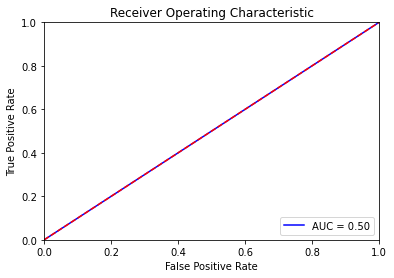

/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/



Running sst2 experiment on orig, N10, run# 6


Stopping after epoch 12. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.17300444841384888

              precision    recall  f1-score   support

           0      1.000     0.001     0.002       912
           1      0.499     1.000     0.666       909

    accuracy                          0.500      1821
   macro avg      0.750     0.501     0.334      1821
weighted avg      0.750     0.500     0.334      1821

Test Set
AUC: 0.5005
Accuracy: 49.9725%


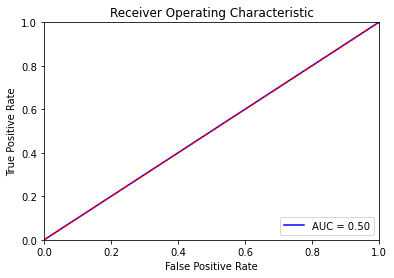



Running sst2 experiment on orig, N10, run# 7


Stopping after epoch 12. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.283067911863327

              precision    recall  f1-score   support

           0      0.000     0.000     0.000       912
           1      0.499     1.000     0.666       909

    accuracy                          0.499      1821
   macro avg      0.250     0.500     0.333      1821
weighted avg      0.249     0.499     0.332      1821

Test Set
AUC: 0.5000
Accuracy: 49.9176%


/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


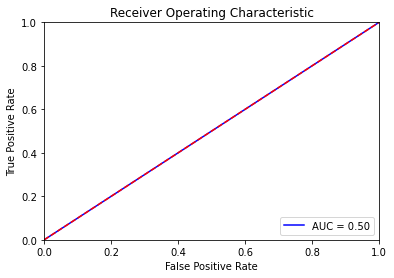

/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/



Running sst2 experiment on orig, N10, run# 8


Stopping after epoch 12. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.21512746810913086

              precision    recall  f1-score   support

           0      0.000     0.000     0.000       912
           1      0.499     1.000     0.666       909

    accuracy                          0.499      1821
   macro avg      0.250     0.500     0.333      1821
weighted avg      0.249     0.499     0.332      1821

Test Set
AUC: 0.5000
Accuracy: 49.9176%


/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


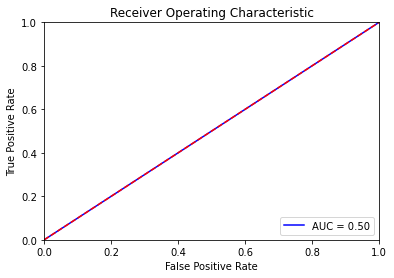

/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/



Running sst2 experiment on orig, N10, run# 9


Stopping after epoch 12. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.24159754812717438

              precision    recall  f1-score   support

           0      0.000     0.000     0.000       912
           1      0.499     1.000     0.666       909

    accuracy                          0.499      1821
   macro avg      0.250     0.500     0.333      1821
weighted avg      0.249     0.499     0.332      1821

Test Set
AUC: 0.5000
Accuracy: 49.9176%


/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


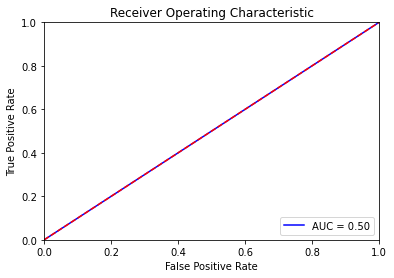

/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/



Running sst2 experiment on orig, N10, run# 10


Stopping after epoch 16. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.1098216250538826

              precision    recall  f1-score   support

           0      0.503     0.815     0.622       912
           1      0.510     0.194     0.281       909

    accuracy                          0.505      1821
   macro avg      0.507     0.504     0.451      1821
weighted avg      0.507     0.505     0.452      1821

Test Set
AUC: 0.5042
Accuracy: 50.4668%


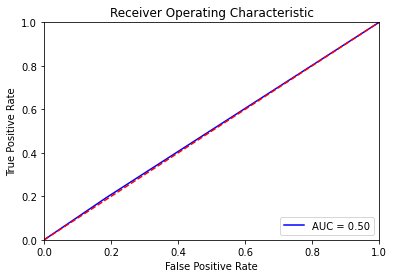

Finished epoch 4 of 1000; error is 0.6175295114517212



Running sst2 experiment on orig, N10, run# 11


Stopping after epoch 12. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.28752151131629944

              precision    recall  f1-score   support

           0      0.501     1.000     0.667       912
           1      0.000     0.000     0.000       909

    accuracy                          0.501      1821
   macro avg      0.250     0.500     0.334      1821
weighted avg      0.251     0.501     0.334      1821

Test Set
AUC: 0.5000
Accuracy: 50.0824%


/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


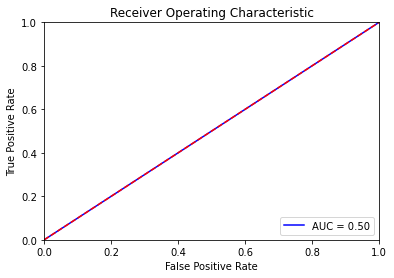

/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/



Running sst2 experiment on para, N10, run# 0


Stopping after epoch 18. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.09668501497071702

              precision    recall  f1-score   support

           0      0.530     0.311     0.392       912
           1      0.511     0.723     0.599       909

    accuracy                          0.517      1821
   macro avg      0.521     0.517     0.496      1821
weighted avg      0.521     0.517     0.495      1821

Test Set
AUC: 0.5171
Accuracy: 51.6749%


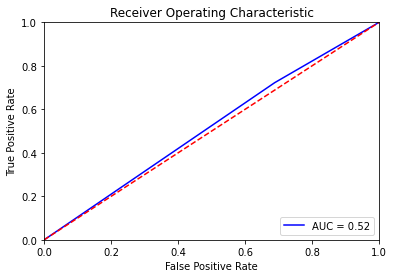

Finished epoch 1 of 1000; error is 1.3705160021781921



Running sst2 experiment on para, N10, run# 1


Stopping after epoch 12. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.03161255456507206

              precision    recall  f1-score   support

           0      0.000     0.000     0.000       912
           1      0.499     1.000     0.666       909

    accuracy                          0.499      1821
   macro avg      0.250     0.500     0.333      1821
weighted avg      0.249     0.499     0.332      1821

Test Set
AUC: 0.5000
Accuracy: 49.9176%


/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


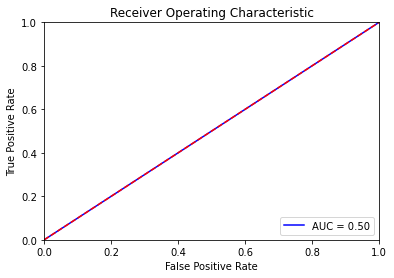

/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/



Running sst2 experiment on para, N10, run# 2


Stopping after epoch 14. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.09596034529386088

              precision    recall  f1-score   support

           0      0.472     0.046     0.084       912
           1      0.498     0.948     0.653       909

    accuracy                          0.496      1821
   macro avg      0.485     0.497     0.368      1821
weighted avg      0.485     0.496     0.368      1821

Test Set
AUC: 0.4972
Accuracy: 49.6431%


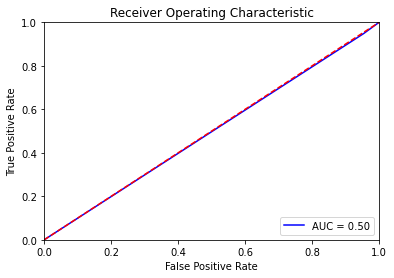



Running sst2 experiment on para, N10, run# 3


Stopping after epoch 12. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.004037567065097392

              precision    recall  f1-score   support

           0      0.000     0.000     0.000       912
           1      0.499     1.000     0.666       909

    accuracy                          0.499      1821
   macro avg      0.250     0.500     0.333      1821
weighted avg      0.249     0.499     0.332      1821

Test Set
AUC: 0.5000
Accuracy: 49.9176%


/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


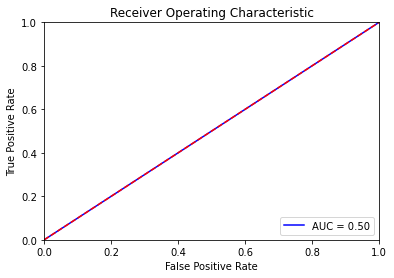

/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/



Running sst2 experiment on para, N10, run# 4


Stopping after epoch 14. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.12765667401254177

              precision    recall  f1-score   support

           0      0.508     0.641     0.567       912
           1      0.511     0.376     0.433       909

    accuracy                          0.509      1821
   macro avg      0.510     0.509     0.500      1821
weighted avg      0.510     0.509     0.500      1821

Test Set
AUC: 0.5088
Accuracy: 50.9061%


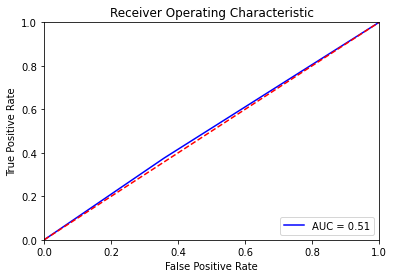

Finished epoch 1 of 1000; error is 1.7362931966781616



Running sst2 experiment on para, N10, run# 5


Stopping after epoch 18. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 5.923715518285633e-05

              precision    recall  f1-score   support

           0      0.000     0.000     0.000       912
           1      0.499     1.000     0.666       909

    accuracy                          0.499      1821
   macro avg      0.250     0.500     0.333      1821
weighted avg      0.249     0.499     0.332      1821

Test Set
AUC: 0.5000
Accuracy: 49.9176%


/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


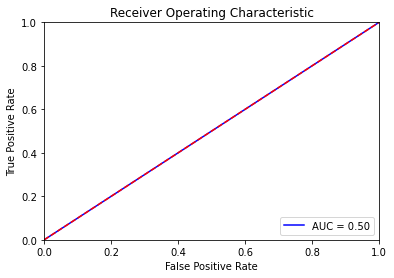

/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/



Running sst2 experiment on para, N10, run# 6


Stopping after epoch 14. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.4522214592434466

              precision    recall  f1-score   support

           0      0.512     0.924     0.659       912
           1      0.601     0.114     0.192       909

    accuracy                          0.520      1821
   macro avg      0.556     0.519     0.425      1821
weighted avg      0.556     0.520     0.426      1821

Test Set
AUC: 0.5194
Accuracy: 52.0044%


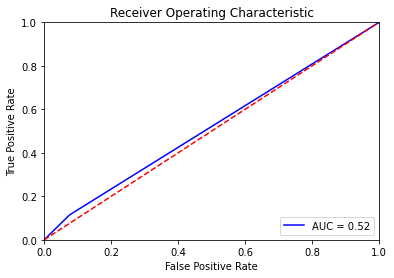

Finished epoch 1 of 1000; error is 1.2426369190216064



Running sst2 experiment on para, N10, run# 7


Stopping after epoch 14. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.13152289018034935

              precision    recall  f1-score   support

           0      0.333     0.002     0.004       912
           1      0.499     0.996     0.664       909

    accuracy                          0.498      1821
   macro avg      0.416     0.499     0.334      1821
weighted avg      0.416     0.498     0.334      1821

Test Set
AUC: 0.4989
Accuracy: 49.8078%


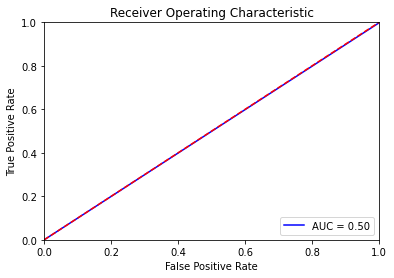

Finished epoch 1 of 1000; error is 2.023628056049347



Running sst2 experiment on para, N10, run# 8


Stopping after epoch 14. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.08007075727979895

              precision    recall  f1-score   support

           0      0.524     0.637     0.575       912
           1      0.536     0.420     0.471       909

    accuracy                          0.529      1821
   macro avg      0.530     0.529     0.523      1821
weighted avg      0.530     0.529     0.523      1821

Test Set
AUC: 0.5287
Accuracy: 52.8830%


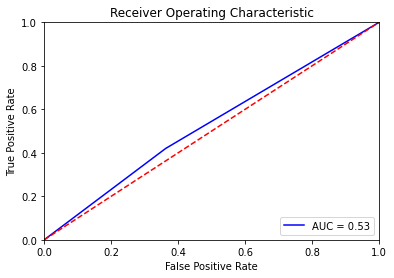

Finished epoch 1 of 1000; error is 2.0711400508880615



Running sst2 experiment on para, N10, run# 9


Stopping after epoch 12. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.004002419853350148

              precision    recall  f1-score   support

           0      0.000     0.000     0.000       912
           1      0.499     1.000     0.666       909

    accuracy                          0.499      1821
   macro avg      0.250     0.500     0.333      1821
weighted avg      0.249     0.499     0.332      1821

Test Set
AUC: 0.5000
Accuracy: 49.9176%


/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


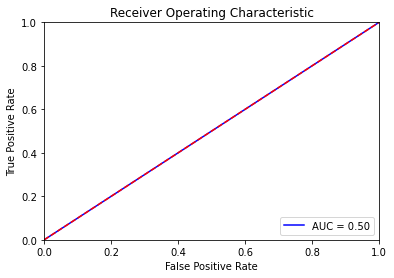

/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/



Running sst2 experiment on para, N10, run# 10


Stopping after epoch 17. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.0595650058821775

              precision    recall  f1-score   support

           0      0.597     0.044     0.082       912
           1      0.503     0.970     0.662       909

    accuracy                          0.506      1821
   macro avg      0.550     0.507     0.372      1821
weighted avg      0.550     0.506     0.372      1821

Test Set
AUC: 0.5071
Accuracy: 50.6315%


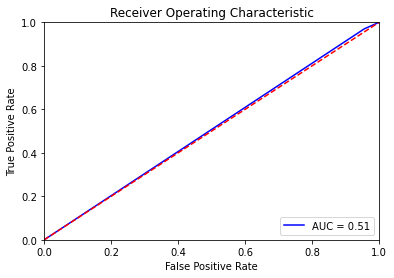

Finished epoch 1 of 1000; error is 1.993670105934143



Running sst2 experiment on para, N10, run# 11


Stopping after epoch 15. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.0005774675523895212

              precision    recall  f1-score   support

           0      0.610     0.055     0.101       912
           1      0.504     0.965     0.662       909

    accuracy                          0.509      1821
   macro avg      0.557     0.510     0.381      1821
weighted avg      0.557     0.509     0.381      1821

Test Set
AUC: 0.5098
Accuracy: 50.9061%


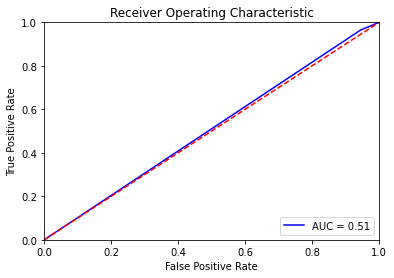



Running sst2 experiment on para_tc, N10, run# 0


Stopping after epoch 16. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.2111375443637371

              precision    recall  f1-score   support

           0      0.491     0.219     0.303       912
           1      0.496     0.772     0.604       909

    accuracy                          0.495      1821
   macro avg      0.494     0.496     0.454      1821
weighted avg      0.494     0.495     0.454      1821

Test Set
AUC: 0.4958
Accuracy: 49.5332%


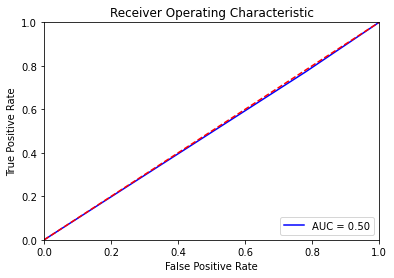



Running sst2 experiment on para_tc, N10, run# 1


Stopping after epoch 14. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.1755606378428638

              precision    recall  f1-score   support

           0      0.504     0.129     0.206       912
           1      0.500     0.872     0.635       909

    accuracy                          0.500      1821
   macro avg      0.502     0.501     0.421      1821
weighted avg      0.502     0.500     0.420      1821

Test Set
AUC: 0.5009
Accuracy: 50.0275%


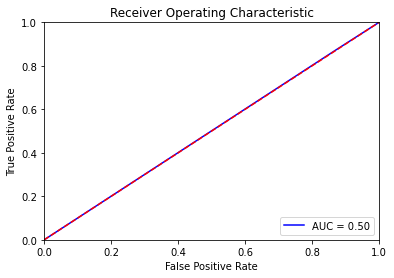



Running sst2 experiment on para_tc, N10, run# 2


Stopping after epoch 12. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.33562071621418

              precision    recall  f1-score   support

           0      0.497     0.530     0.513       912
           1      0.495     0.462     0.478       909

    accuracy                          0.496      1821
   macro avg      0.496     0.496     0.495      1821
weighted avg      0.496     0.496     0.495      1821

Test Set
AUC: 0.4958
Accuracy: 49.5881%


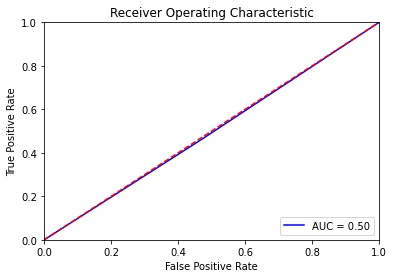



Running sst2 experiment on para_tc, N10, run# 3


Stopping after epoch 12. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.2899136447485944

              precision    recall  f1-score   support

           0      0.000     0.000     0.000       912
           1      0.499     1.000     0.666       909

    accuracy                          0.499      1821
   macro avg      0.250     0.500     0.333      1821
weighted avg      0.249     0.499     0.332      1821

Test Set
AUC: 0.5000
Accuracy: 49.9176%


/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


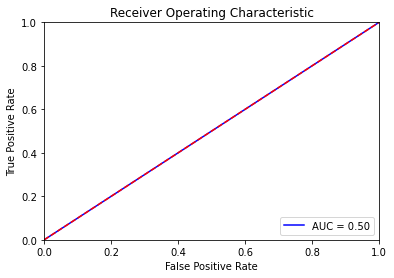

/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/



Running sst2 experiment on para_tc, N10, run# 4


Stopping after epoch 15. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.000931406783820421

              precision    recall  f1-score   support

           0      0.489     0.606     0.541       912
           1      0.479     0.363     0.413       909

    accuracy                          0.485      1821
   macro avg      0.484     0.485     0.477      1821
weighted avg      0.484     0.485     0.477      1821

Test Set
AUC: 0.4847
Accuracy: 48.4898%


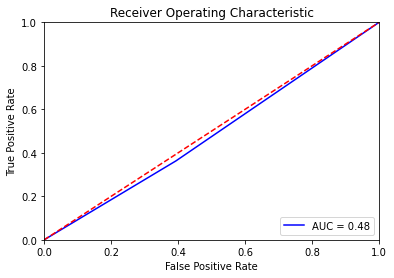



Running sst2 experiment on para_tc, N10, run# 5


Stopping after epoch 16. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.22522240573925956

              precision    recall  f1-score   support

           0      0.630     0.032     0.061       912
           1      0.503     0.981     0.665       909

    accuracy                          0.506      1821
   macro avg      0.566     0.507     0.363      1821
weighted avg      0.567     0.506     0.362      1821

Test Set
AUC: 0.5065
Accuracy: 50.5766%


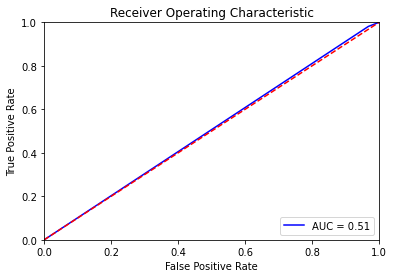



Running sst2 experiment on para_tc, N10, run# 6


Stopping after epoch 18. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.3479897251963848

              precision    recall  f1-score   support

           0      0.547     0.565     0.556       912
           1      0.549     0.531     0.540       909

    accuracy                          0.548      1821
   macro avg      0.548     0.548     0.548      1821
weighted avg      0.548     0.548     0.548      1821

Test Set
AUC: 0.5480
Accuracy: 54.8051%


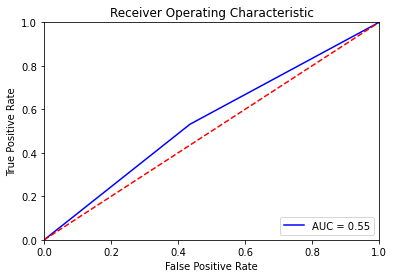



Running sst2 experiment on para_tc, N10, run# 7


Stopping after epoch 17. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.1674549498129636

              precision    recall  f1-score   support

           0      0.542     0.663     0.596       912
           1      0.564     0.437     0.492       909

    accuracy                          0.550      1821
   macro avg      0.553     0.550     0.544      1821
weighted avg      0.553     0.550     0.544      1821

Test Set
AUC: 0.5501
Accuracy: 55.0247%


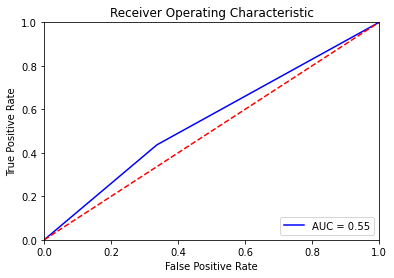



Running sst2 experiment on para_tc, N10, run# 8


Stopping after epoch 16. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.12295019975863397

              precision    recall  f1-score   support

           0      0.574     0.081     0.142       912
           1      0.505     0.939     0.657       909

    accuracy                          0.510      1821
   macro avg      0.539     0.510     0.399      1821
weighted avg      0.539     0.510     0.399      1821

Test Set
AUC: 0.5103
Accuracy: 50.9610%


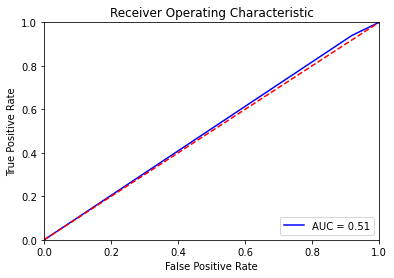



Running sst2 experiment on para_tc, N10, run# 9


Stopping after epoch 17. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.1905061588913668

              precision    recall  f1-score   support

           0      0.524     0.158     0.243       912
           1      0.503     0.856     0.634       909

    accuracy                          0.506      1821
   macro avg      0.513     0.507     0.438      1821
weighted avg      0.513     0.506     0.438      1821

Test Set
AUC: 0.5069
Accuracy: 50.6315%


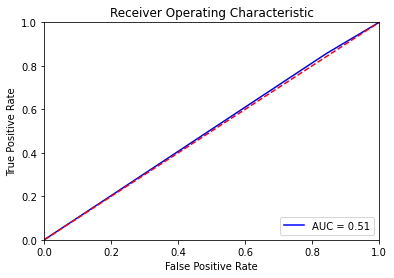



Running sst2 experiment on para_tc, N10, run# 10


Stopping after epoch 14. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.16781379833901156

              precision    recall  f1-score   support

           0      0.585     0.332     0.424       912
           1      0.533     0.763     0.627       909

    accuracy                          0.548      1821
   macro avg      0.559     0.548     0.526      1821
weighted avg      0.559     0.548     0.525      1821

Test Set
AUC: 0.5479
Accuracy: 54.7501%


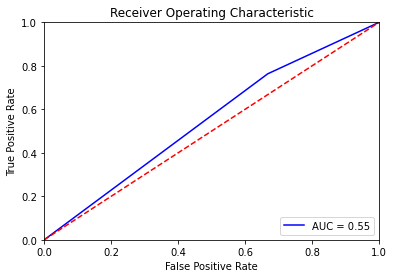



Running sst2 experiment on para_tc, N10, run# 11


Stopping after epoch 14. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 1.3963254585396498

              precision    recall  f1-score   support

           0      0.552     0.729     0.629       912
           1      0.600     0.407     0.485       909

    accuracy                          0.568      1821
   macro avg      0.576     0.568     0.557      1821
weighted avg      0.576     0.568     0.557      1821

Test Set
AUC: 0.5681
Accuracy: 56.8369%


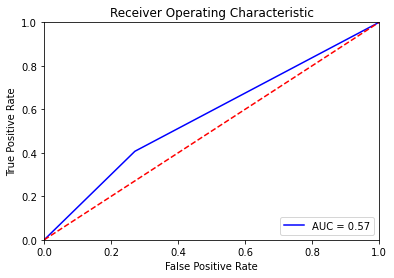

Finished epoch 1 of 1000; error is 1.3269808888435364



Running sst2 experiment on para_editdist, N10, run# 0


Stopping after epoch 12. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.14297611452639103

              precision    recall  f1-score   support

           0      0.000     0.000     0.000       912
           1      0.499     1.000     0.666       909

    accuracy                          0.499      1821
   macro avg      0.250     0.500     0.333      1821
weighted avg      0.249     0.499     0.332      1821

Test Set
AUC: 0.5000
Accuracy: 49.9176%


/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


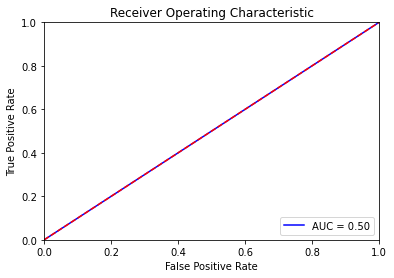

/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/



Running sst2 experiment on para_editdist, N10, run# 1


Stopping after epoch 16. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.02521773800253868

              precision    recall  f1-score   support

           0      0.507     0.190     0.276       912
           1      0.501     0.815     0.620       909

    accuracy                          0.502      1821
   macro avg      0.504     0.502     0.448      1821
weighted avg      0.504     0.502     0.448      1821

Test Set
AUC: 0.5024
Accuracy: 50.1922%


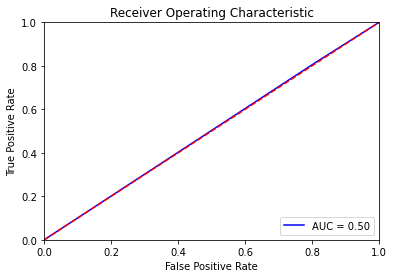

Finished epoch 1 of 1000; error is 1.3961453437805176



Running sst2 experiment on para_editdist, N10, run# 2


Stopping after epoch 12. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 1.2738955300301313

              precision    recall  f1-score   support

           0      1.000     0.001     0.002       912
           1      0.499     1.000     0.666       909

    accuracy                          0.500      1821
   macro avg      0.750     0.501     0.334      1821
weighted avg      0.750     0.500     0.334      1821

Test Set
AUC: 0.5005
Accuracy: 49.9725%


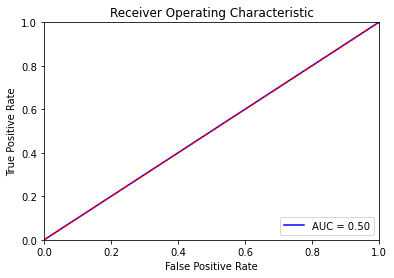

Finished epoch 1 of 1000; error is 1.5059324204921722



Running sst2 experiment on para_editdist, N10, run# 3


Stopping after epoch 23. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 1.6378479358536424e-05

              precision    recall  f1-score   support

           0      0.000     0.000     0.000       912
           1      0.499     1.000     0.666       909

    accuracy                          0.499      1821
   macro avg      0.250     0.500     0.333      1821
weighted avg      0.249     0.499     0.332      1821

Test Set
AUC: 0.5000
Accuracy: 49.9176%


/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


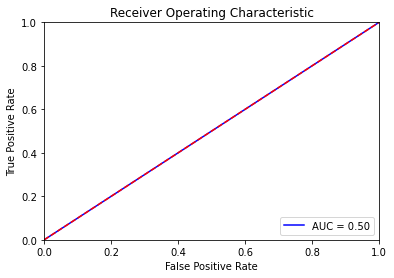

/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/



Running sst2 experiment on para_editdist, N10, run# 4


Stopping after epoch 16. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.41424769163131714

              precision    recall  f1-score   support

           0      0.473     0.388     0.426       912
           1      0.479     0.565     0.519       909

    accuracy                          0.477      1821
   macro avg      0.476     0.477     0.473      1821
weighted avg      0.476     0.477     0.473      1821

Test Set
AUC: 0.4768
Accuracy: 47.6661%


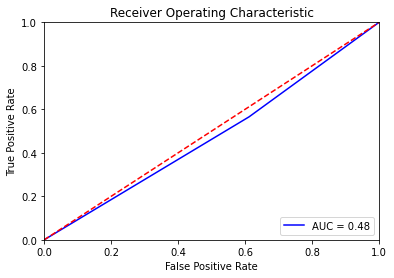

Finished epoch 1 of 1000; error is 1.8091568350791931



Running sst2 experiment on para_editdist, N10, run# 5


Stopping after epoch 17. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.00018867677499301294

              precision    recall  f1-score   support

           0      0.000     0.000     0.000       912
           1      0.499     1.000     0.666       909

    accuracy                          0.499      1821
   macro avg      0.250     0.500     0.333      1821
weighted avg      0.249     0.499     0.332      1821

Test Set
AUC: 0.5000
Accuracy: 49.9176%


/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


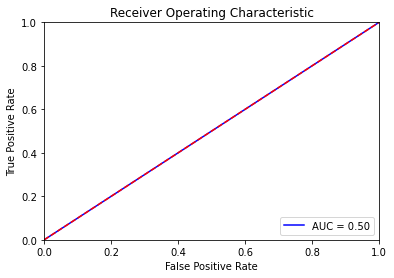

/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/



Running sst2 experiment on para_editdist, N10, run# 6


Stopping after epoch 16. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.15887748586101225

              precision    recall  f1-score   support

           0      0.502     0.998     0.668       912
           1      0.750     0.007     0.013       909

    accuracy                          0.503      1821
   macro avg      0.626     0.502     0.340      1821
weighted avg      0.626     0.503     0.341      1821

Test Set
AUC: 0.5022
Accuracy: 50.3020%


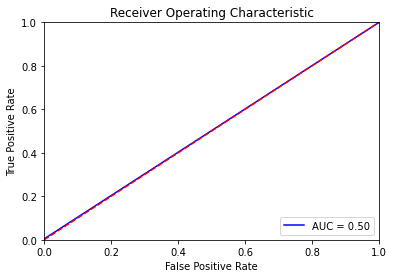

Finished epoch 2 of 1000; error is 1.1075039505958557



Running sst2 experiment on para_editdist, N10, run# 7


Stopping after epoch 12. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.13812854513525963

              precision    recall  f1-score   support

           0      0.000     0.000     0.000       912
           1      0.499     1.000     0.666       909

    accuracy                          0.499      1821
   macro avg      0.250     0.500     0.333      1821
weighted avg      0.249     0.499     0.332      1821

Test Set
AUC: 0.5000
Accuracy: 49.9176%


/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


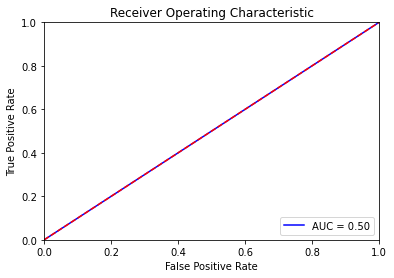

/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/



Running sst2 experiment on para_editdist, N10, run# 8


Stopping after epoch 16. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.11256455995589931

              precision    recall  f1-score   support

           0      0.500     0.951     0.655       912
           1      0.477     0.045     0.082       909

    accuracy                          0.499      1821
   macro avg      0.488     0.498     0.369      1821
weighted avg      0.488     0.499     0.369      1821

Test Set
AUC: 0.4979
Accuracy: 49.8627%


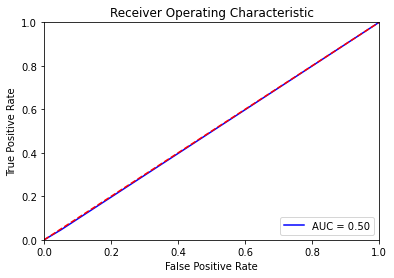

Finished epoch 2 of 1000; error is 1.7532120347023013



Running sst2 experiment on para_editdist, N10, run# 9


Stopping after epoch 13. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.002197942063503433

              precision    recall  f1-score   support

           0      0.000     0.000     0.000       912
           1      0.499     1.000     0.666       909

    accuracy                          0.499      1821
   macro avg      0.250     0.500     0.333      1821
weighted avg      0.249     0.499     0.332      1821

Test Set
AUC: 0.5000
Accuracy: 49.9176%


/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


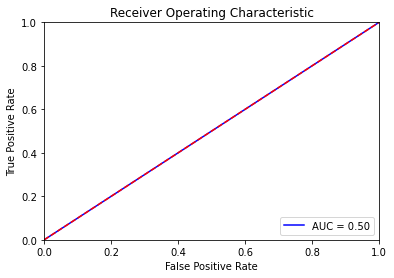

/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/



Running sst2 experiment on para_editdist, N10, run# 10


Stopping after epoch 16. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.11403655633330345

              precision    recall  f1-score   support

           0      0.503     0.986     0.666       912
           1      0.618     0.023     0.045       909

    accuracy                          0.505      1821
   macro avg      0.560     0.504     0.355      1821
weighted avg      0.560     0.505     0.356      1821

Test Set
AUC: 0.5044
Accuracy: 50.5217%


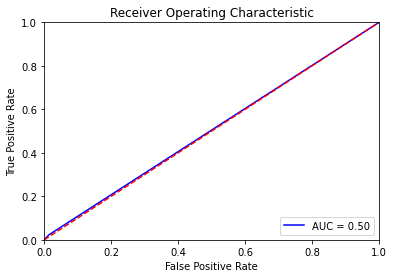

Finished epoch 2 of 1000; error is 1.2149754762649536



Running sst2 experiment on para_editdist, N10, run# 11


Stopping after epoch 15. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.12387905456125736

              precision    recall  f1-score   support

           0      0.594     0.163     0.256       912
           1      0.514     0.888     0.651       909

    accuracy                          0.525      1821
   macro avg      0.554     0.526     0.454      1821
weighted avg      0.554     0.525     0.453      1821

Test Set
AUC: 0.5256
Accuracy: 52.4986%


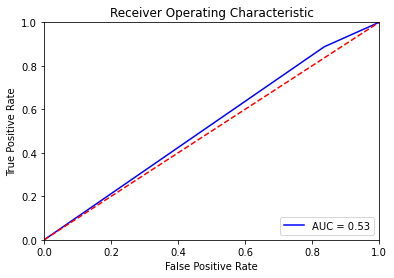



Running sst2 experiment on para_tc_editdist, N10, run# 0


Stopping after epoch 17. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 6.506500227487777e-05

              precision    recall  f1-score   support

           0      0.527     0.150     0.234       912
           1      0.504     0.865     0.636       909

    accuracy                          0.507      1821
   macro avg      0.515     0.507     0.435      1821
weighted avg      0.515     0.507     0.435      1821

Test Set
AUC: 0.5075
Accuracy: 50.6864%


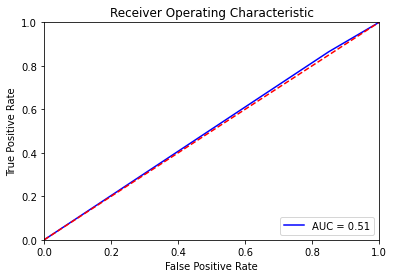



Running sst2 experiment on para_tc_editdist, N10, run# 1


Stopping after epoch 15. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.15291051965323277

              precision    recall  f1-score   support

           0      0.524     0.060     0.108       912
           1      0.501     0.945     0.654       909

    accuracy                          0.502      1821
   macro avg      0.512     0.503     0.381      1821
weighted avg      0.512     0.502     0.381      1821

Test Set
AUC: 0.5027
Accuracy: 50.1922%


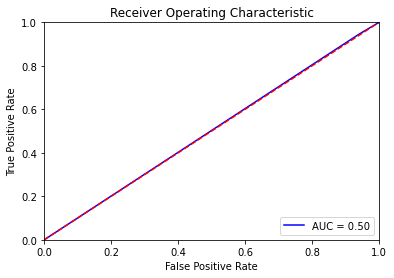

Finished epoch 1 of 1000; error is 3.4379355907440186



Running sst2 experiment on para_tc_editdist, N10, run# 2


Stopping after epoch 17. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.25108562409877777

              precision    recall  f1-score   support

           0      0.491     0.384     0.431       912
           1      0.493     0.601     0.541       909

    accuracy                          0.492      1821
   macro avg      0.492     0.492     0.486      1821
weighted avg      0.492     0.492     0.486      1821

Test Set
AUC: 0.4922
Accuracy: 49.2037%


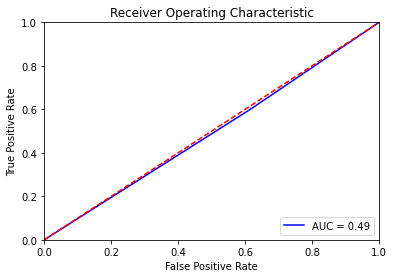



Running sst2 experiment on para_tc_editdist, N10, run# 3


Stopping after epoch 12. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.19619278453288658

              precision    recall  f1-score   support

           0      0.000     0.000     0.000       912
           1      0.499     1.000     0.666       909

    accuracy                          0.499      1821
   macro avg      0.250     0.500     0.333      1821
weighted avg      0.249     0.499     0.332      1821

Test Set
AUC: 0.5000
Accuracy: 49.9176%


/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


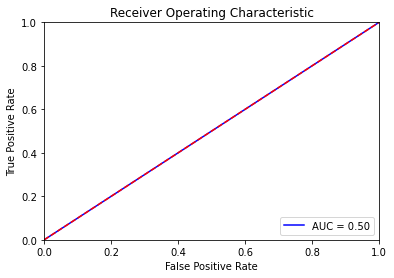

/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/



Running sst2 experiment on para_tc_editdist, N10, run# 4


Stopping after epoch 12. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.14580333686899394

              precision    recall  f1-score   support

           0      0.000     0.000     0.000       912
           1      0.499     1.000     0.666       909

    accuracy                          0.499      1821
   macro avg      0.250     0.500     0.333      1821
weighted avg      0.249     0.499     0.332      1821

Test Set
AUC: 0.5000
Accuracy: 49.9176%


/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


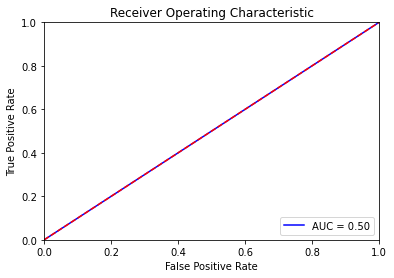

/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/



Running sst2 experiment on para_tc_editdist, N10, run# 5


Stopping after epoch 18. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.1012291650113184

              precision    recall  f1-score   support

           0      0.586     0.120     0.199       912
           1      0.509     0.915     0.654       909

    accuracy                          0.517      1821
   macro avg      0.547     0.517     0.426      1821
weighted avg      0.548     0.517     0.426      1821

Test Set
AUC: 0.5174
Accuracy: 51.6749%


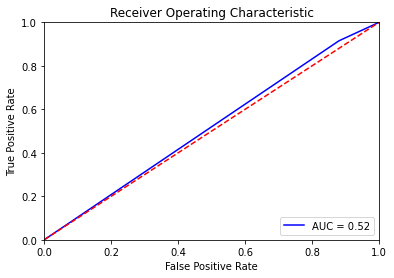



Running sst2 experiment on para_tc_editdist, N10, run# 6


Stopping after epoch 14. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.26687479205429554

              precision    recall  f1-score   support

           0      0.507     0.973     0.667       912
           1      0.658     0.053     0.098       909

    accuracy                          0.513      1821
   macro avg      0.582     0.513     0.382      1821
weighted avg      0.582     0.513     0.383      1821

Test Set
AUC: 0.5127
Accuracy: 51.3454%


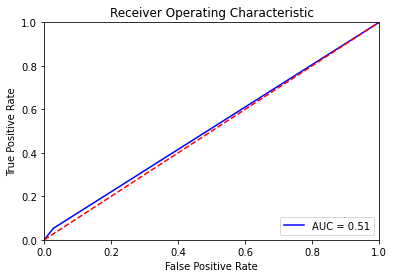



Running sst2 experiment on para_tc_editdist, N10, run# 7


Stopping after epoch 15. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.1574821302201599

              precision    recall  f1-score   support

           0      0.552     0.221     0.316       912
           1      0.512     0.820     0.630       909

    accuracy                          0.520      1821
   macro avg      0.532     0.521     0.473      1821
weighted avg      0.532     0.520     0.473      1821

Test Set
AUC: 0.5205
Accuracy: 52.0044%


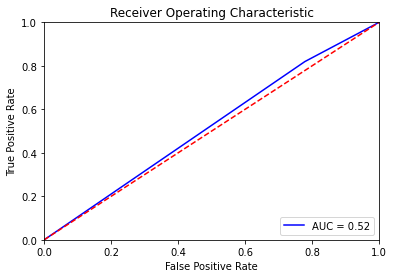



Running sst2 experiment on para_tc_editdist, N10, run# 8


Stopping after epoch 14. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.13193039241014048

              precision    recall  f1-score   support

           0      0.588     0.183     0.279       912
           1      0.515     0.871     0.648       909

    accuracy                          0.527      1821
   macro avg      0.552     0.527     0.463      1821
weighted avg      0.552     0.527     0.463      1821

Test Set
AUC: 0.5272
Accuracy: 52.6634%


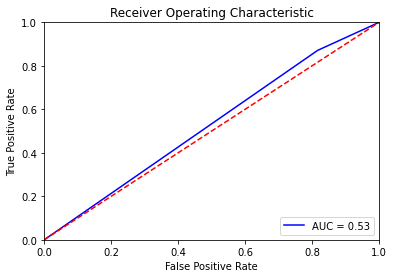



Running sst2 experiment on para_tc_editdist, N10, run# 9


Stopping after epoch 15. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.23502063029445708

              precision    recall  f1-score   support

           0      0.500     0.039     0.073       912
           1      0.499     0.960     0.657       909

    accuracy                          0.499      1821
   macro avg      0.500     0.500     0.365      1821
weighted avg      0.500     0.499     0.365      1821

Test Set
AUC: 0.4999
Accuracy: 49.9176%


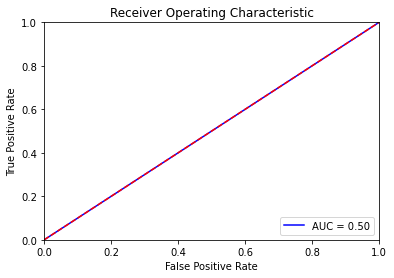



Running sst2 experiment on para_tc_editdist, N10, run# 10


Stopping after epoch 15. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.10739545382239157

              precision    recall  f1-score   support

           0      0.540     0.544     0.542       912
           1      0.539     0.536     0.538       909

    accuracy                          0.540      1821
   macro avg      0.540     0.540     0.540      1821
weighted avg      0.540     0.540     0.540      1821

Test Set
AUC: 0.5398
Accuracy: 53.9813%


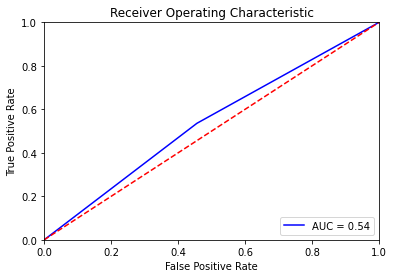



Running sst2 experiment on para_tc_editdist, N10, run# 11


Stopping after epoch 15. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.09453508467413485

              precision    recall  f1-score   support

           0      0.510     0.942     0.662       912
           1      0.613     0.092     0.161       909

    accuracy                          0.518      1821
   macro avg      0.562     0.517     0.411      1821
weighted avg      0.562     0.518     0.412      1821

Test Set
AUC: 0.5171
Accuracy: 51.7847%


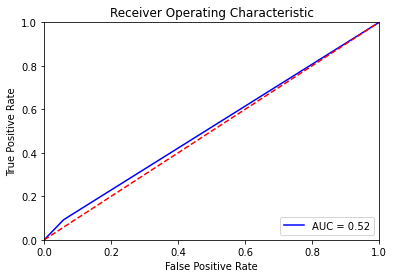

Finished epoch 1 of 1000; error is 1.9497302174568176



Running sst2 experiment on tc, N10, run# 0


Stopping after epoch 12. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.004562523448839784

              precision    recall  f1-score   support

           0      0.000     0.000     0.000       912
           1      0.499     1.000     0.666       909

    accuracy                          0.499      1821
   macro avg      0.250     0.500     0.333      1821
weighted avg      0.249     0.499     0.332      1821

Test Set
AUC: 0.5000
Accuracy: 49.9176%


/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


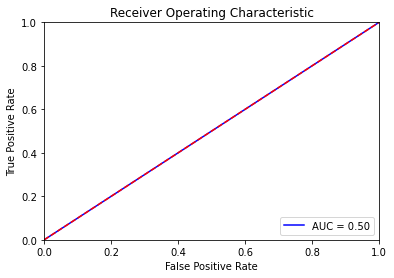

/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/



Running sst2 experiment on tc, N10, run# 1


Stopping after epoch 18. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.17614137195050716

              precision    recall  f1-score   support

           0      0.564     0.207     0.303       912
           1      0.513     0.839     0.637       909

    accuracy                          0.523      1821
   macro avg      0.539     0.523     0.470      1821
weighted avg      0.539     0.523     0.470      1821

Test Set
AUC: 0.5233
Accuracy: 52.2790%


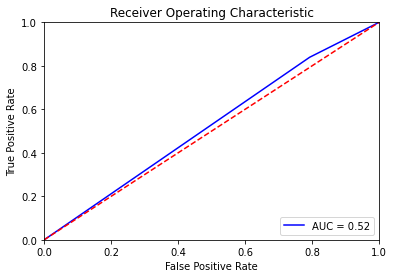



Running sst2 experiment on tc, N10, run# 2


Stopping after epoch 15. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.1233140742406249

              precision    recall  f1-score   support

           0      0.495     0.848     0.625       912
           1      0.461     0.131     0.204       909

    accuracy                          0.490      1821
   macro avg      0.478     0.489     0.414      1821
weighted avg      0.478     0.490     0.415      1821

Test Set
AUC: 0.4893
Accuracy: 48.9841%


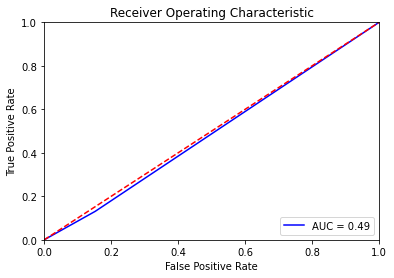



Running sst2 experiment on tc, N10, run# 3


Stopping after epoch 12. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.10417699546087533

              precision    recall  f1-score   support

           0      0.000     0.000     0.000       912
           1      0.499     1.000     0.666       909

    accuracy                          0.499      1821
   macro avg      0.250     0.500     0.333      1821
weighted avg      0.249     0.499     0.332      1821

Test Set
AUC: 0.5000
Accuracy: 49.9176%


/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


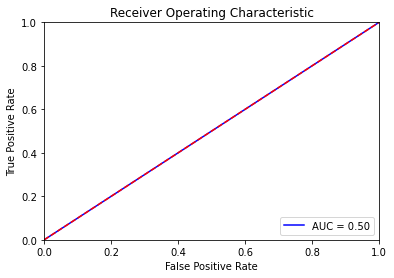

/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/



Running sst2 experiment on tc, N10, run# 4


Stopping after epoch 17. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.00046648093120893463

              precision    recall  f1-score   support

           0      0.448     0.333     0.382       912
           1      0.468     0.589     0.521       909

    accuracy                          0.461      1821
   macro avg      0.458     0.461     0.452      1821
weighted avg      0.458     0.461     0.452      1821

Test Set
AUC: 0.4609
Accuracy: 46.0736%


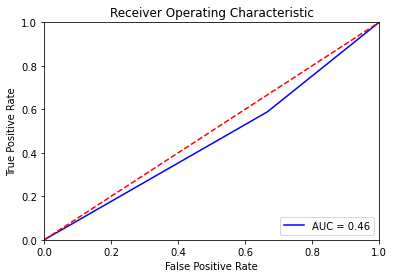



Running sst2 experiment on tc, N10, run# 5


Stopping after epoch 26. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.15392458904534578

              precision    recall  f1-score   support

           0      0.536     0.334     0.412       912
           1      0.515     0.710     0.597       909

    accuracy                          0.522      1821
   macro avg      0.526     0.522     0.504      1821
weighted avg      0.526     0.522     0.504      1821

Test Set
AUC: 0.5220
Accuracy: 52.1691%


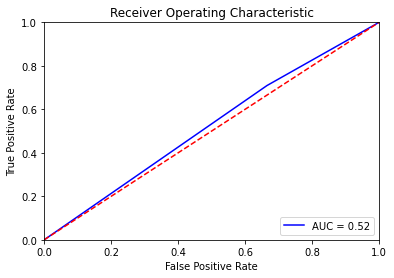

Finished epoch 1 of 1000; error is 2.033236563205719



Running sst2 experiment on tc, N10, run# 6


Stopping after epoch 13. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.40367619693279266

              precision    recall  f1-score   support

           0      0.535     0.552     0.543       912
           1      0.536     0.519     0.527       909

    accuracy                          0.535      1821
   macro avg      0.535     0.535     0.535      1821
weighted avg      0.535     0.535     0.535      1821

Test Set
AUC: 0.5354
Accuracy: 53.5420%


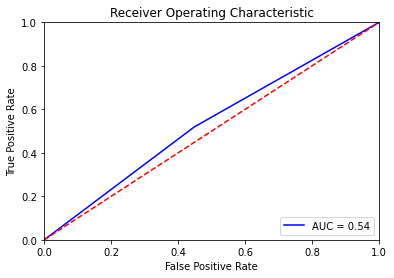

Finished epoch 1 of 1000; error is 1.9358645677566528



Running sst2 experiment on tc, N10, run# 7


Stopping after epoch 19. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.1607105489820242

              precision    recall  f1-score   support

           0      0.543     0.438     0.485       912
           1      0.528     0.630     0.574       909

    accuracy                          0.534      1821
   macro avg      0.535     0.534     0.529      1821
weighted avg      0.535     0.534     0.529      1821

Test Set
AUC: 0.5339
Accuracy: 53.3773%


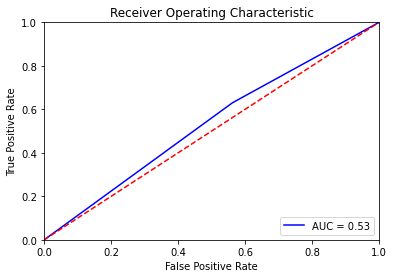

Finished epoch 1 of 1000; error is 2.0900676250457764



Running sst2 experiment on tc, N10, run# 8


Stopping after epoch 24. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 5.6564636395251e-05

              precision    recall  f1-score   support

           0      0.536     0.746     0.624       912
           1      0.580     0.352     0.438       909

    accuracy                          0.549      1821
   macro avg      0.558     0.549     0.531      1821
weighted avg      0.558     0.549     0.531      1821

Test Set
AUC: 0.5488
Accuracy: 54.9149%


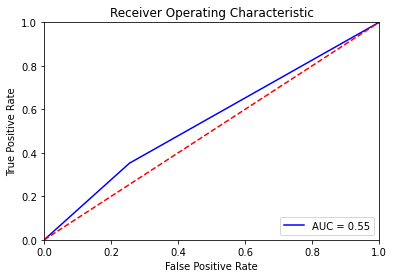

Finished epoch 1 of 1000; error is 1.8922069072723389



Running sst2 experiment on tc, N10, run# 9


Stopping after epoch 14. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.2389516718685627

              precision    recall  f1-score   support

           0      0.000     0.000     0.000       912
           1      0.499     1.000     0.666       909

    accuracy                          0.499      1821
   macro avg      0.250     0.500     0.333      1821
weighted avg      0.249     0.499     0.332      1821

Test Set
AUC: 0.5000
Accuracy: 49.9176%


/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


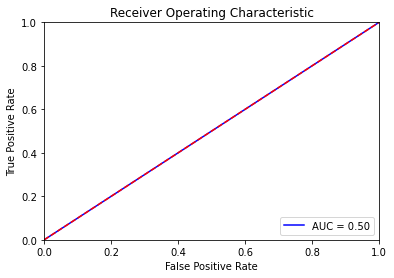

/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/



Running sst2 experiment on tc, N10, run# 10


Stopping after epoch 13. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.01700163958594203

              precision    recall  f1-score   support

           0      0.530     0.450     0.486       912
           1      0.521     0.600     0.557       909

    accuracy                          0.524      1821
   macro avg      0.525     0.525     0.522      1821
weighted avg      0.525     0.524     0.522      1821

Test Set
AUC: 0.5246
Accuracy: 52.4437%


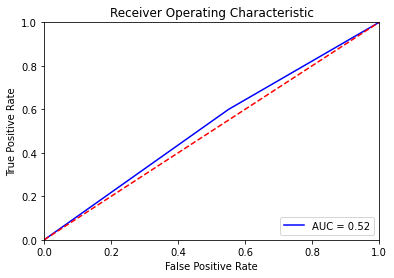

Finished epoch 1 of 1000; error is 1.9621567130088806



Running sst2 experiment on tc, N10, run# 11


Stopping after epoch 17. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.07910328020807356

              precision    recall  f1-score   support

           0      0.517     0.886     0.653       912
           1      0.595     0.168     0.262       909

    accuracy                          0.528      1821
   macro avg      0.556     0.527     0.458      1821
weighted avg      0.556     0.528     0.458      1821

Test Set
AUC: 0.5271
Accuracy: 52.7732%


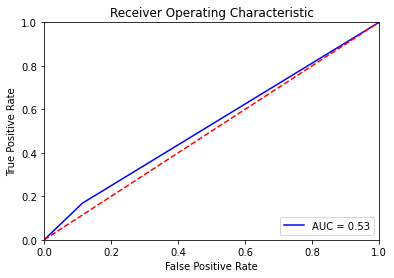

Finished epoch 1 of 1000; error is 2.0708699822425842



Running sst2 experiment on tc_editdist, N10, run# 0


Stopping after epoch 12. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.00034510731438786024

              precision    recall  f1-score   support

           0      0.000     0.000     0.000       912
           1      0.499     1.000     0.666       909

    accuracy                          0.499      1821
   macro avg      0.250     0.500     0.333      1821
weighted avg      0.249     0.499     0.332      1821

Test Set
AUC: 0.5000
Accuracy: 49.9176%


/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


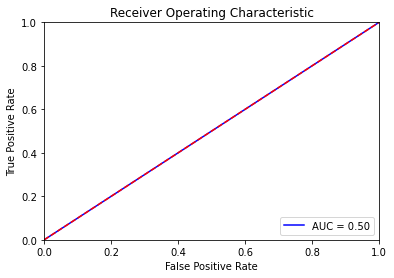

/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/



Running sst2 experiment on tc_editdist, N10, run# 1


Stopping after epoch 19. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.13322927569970489

              precision    recall  f1-score   support

           0      0.502     0.136     0.214       912
           1      0.499     0.865     0.633       909

    accuracy                          0.500      1821
   macro avg      0.501     0.500     0.424      1821
weighted avg      0.501     0.500     0.423      1821

Test Set
AUC: 0.5003
Accuracy: 49.9725%


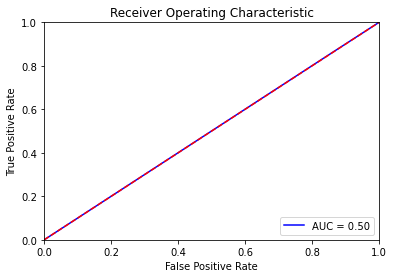

Finished epoch 1 of 1000; error is 2.041120946407318



Running sst2 experiment on tc_editdist, N10, run# 2


Stopping after epoch 14. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.30053868889808655

              precision    recall  f1-score   support

           0      0.525     0.414     0.463       912
           1      0.515     0.624     0.564       909

    accuracy                          0.519      1821
   macro avg      0.520     0.519     0.514      1821
weighted avg      0.520     0.519     0.514      1821

Test Set
AUC: 0.5191
Accuracy: 51.8946%


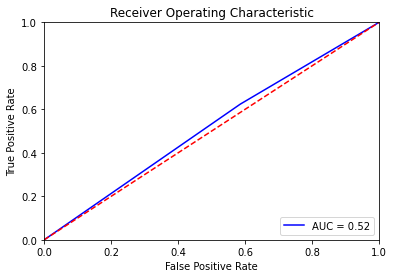

Finished epoch 1 of 1000; error is 1.6153618097305298



Running sst2 experiment on tc_editdist, N10, run# 3


Stopping after epoch 12. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.23984474502503872

              precision    recall  f1-score   support

           0      0.000     0.000     0.000       912
           1      0.499     1.000     0.666       909

    accuracy                          0.499      1821
   macro avg      0.250     0.500     0.333      1821
weighted avg      0.249     0.499     0.332      1821

Test Set
AUC: 0.5000
Accuracy: 49.9176%


/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


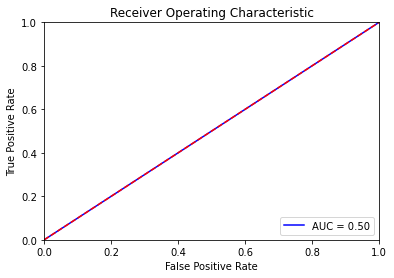

/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/



Running sst2 experiment on tc_editdist, N10, run# 4


Stopping after epoch 25. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.0010086469483212568

              precision    recall  f1-score   support

           0      0.448     0.373     0.407       912
           1      0.461     0.539     0.497       909

    accuracy                          0.456      1821
   macro avg      0.455     0.456     0.452      1821
weighted avg      0.455     0.456     0.452      1821

Test Set
AUC: 0.4559
Accuracy: 45.5794%


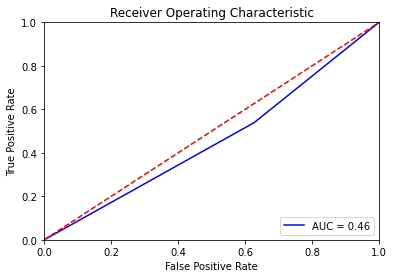

Finished epoch 1 of 1000; error is 1.9494269490242004



Running sst2 experiment on tc_editdist, N10, run# 5


Stopping after epoch 17. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.3237282484769821

              precision    recall  f1-score   support

           0      0.570     0.192     0.287       912
           1      0.513     0.855     0.641       909

    accuracy                          0.523      1821
   macro avg      0.542     0.523     0.464      1821
weighted avg      0.542     0.523     0.464      1821

Test Set
AUC: 0.5233
Accuracy: 52.2790%


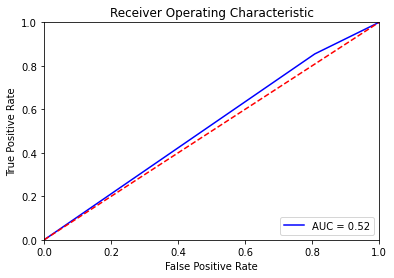

Finished epoch 1 of 1000; error is 2.0502166748046875



Running sst2 experiment on tc_editdist, N10, run# 6


Stopping after epoch 16. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.4047710672020912

              precision    recall  f1-score   support

           0      0.571     0.118     0.196       912
           1      0.507     0.911     0.652       909

    accuracy                          0.514      1821
   macro avg      0.539     0.515     0.424      1821
weighted avg      0.539     0.514     0.424      1821

Test Set
AUC: 0.5147
Accuracy: 51.4003%


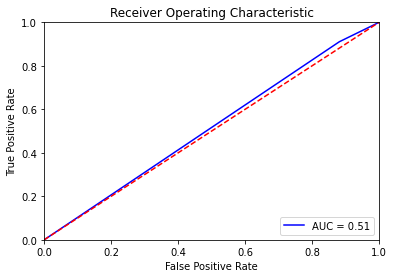

Finished epoch 1 of 1000; error is 2.066755712032318



Running sst2 experiment on tc_editdist, N10, run# 7


Stopping after epoch 16. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.16659043077379465

              precision    recall  f1-score   support

           0      0.545     0.106     0.178       912
           1      0.504     0.911     0.649       909

    accuracy                          0.508      1821
   macro avg      0.524     0.509     0.413      1821
weighted avg      0.524     0.508     0.413      1821

Test Set
AUC: 0.5086
Accuracy: 50.7963%


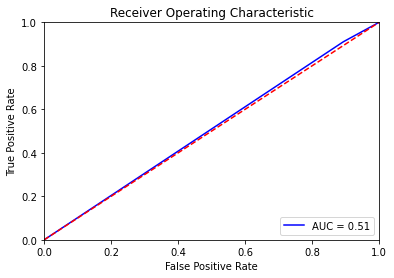

Finished epoch 1 of 1000; error is 2.121441125869751



Running sst2 experiment on tc_editdist, N10, run# 8


Stopping after epoch 12. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.02222877088934183

              precision    recall  f1-score   support

           0      0.000     0.000     0.000       912
           1      0.499     1.000     0.666       909

    accuracy                          0.499      1821
   macro avg      0.250     0.500     0.333      1821
weighted avg      0.249     0.499     0.332      1821

Test Set
AUC: 0.5000
Accuracy: 49.9176%


/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


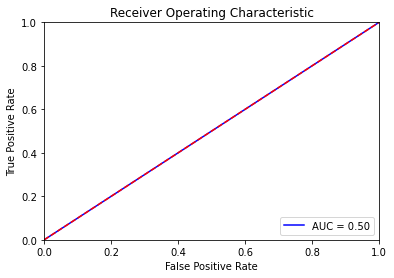

/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/



Running sst2 experiment on tc_editdist, N10, run# 9


Stopping after epoch 29. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.22934532165527344

              precision    recall  f1-score   support

           0      0.522     0.154     0.237       912
           1      0.503     0.859     0.634       909

    accuracy                          0.506      1821
   macro avg      0.513     0.506     0.436      1821
weighted avg      0.513     0.506     0.436      1821

Test Set
AUC: 0.5063
Accuracy: 50.5766%


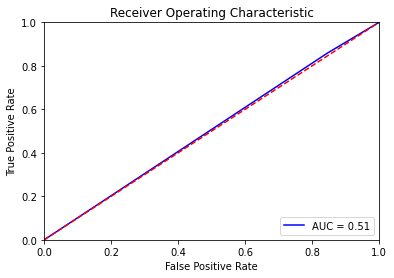



Running sst2 experiment on tc_editdist, N10, run# 10


Stopping after epoch 16. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.0012497530988184735

              precision    recall  f1-score   support

           0      0.571     0.385     0.460       912
           1      0.535     0.710     0.610       909

    accuracy                          0.547      1821
   macro avg      0.553     0.547     0.535      1821
weighted avg      0.553     0.547     0.535      1821

Test Set
AUC: 0.5472
Accuracy: 54.6952%


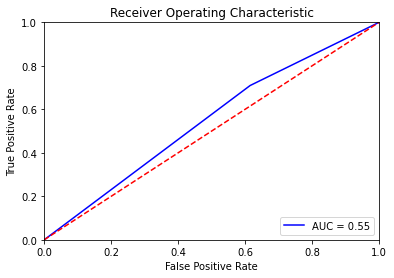



Running sst2 experiment on tc_editdist, N10, run# 11


Stopping after epoch 14. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.1459716772660613

              precision    recall  f1-score   support

           0      0.527     0.227     0.317       912
           1      0.506     0.795     0.619       909

    accuracy                          0.511      1821
   macro avg      0.517     0.511     0.468      1821
weighted avg      0.517     0.511     0.468      1821

Test Set
AUC: 0.5112
Accuracy: 51.0708%


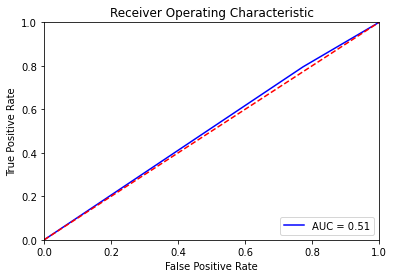



Running sst2 experiment on eda, N10, run# 0


Stopping after epoch 15. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.0023782977004884742

              precision    recall  f1-score   support

           0      0.438     0.008     0.015       912
           1      0.499     0.990     0.663       909

    accuracy                          0.498      1821
   macro avg      0.468     0.499     0.339      1821
weighted avg      0.468     0.498     0.339      1821

Test Set
AUC: 0.4989
Accuracy: 49.8078%


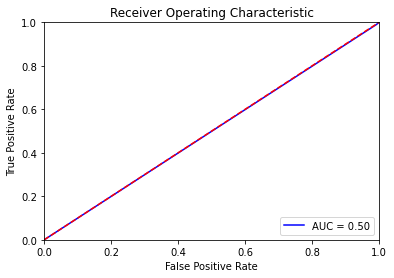



Running sst2 experiment on eda, N10, run# 1


Stopping after epoch 13. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.0011852444092710357

              precision    recall  f1-score   support

           0      0.568     0.161     0.251       912
           1      0.510     0.877     0.645       909

    accuracy                          0.518      1821
   macro avg      0.539     0.519     0.448      1821
weighted avg      0.539     0.518     0.448      1821

Test Set
AUC: 0.5190
Accuracy: 51.8396%


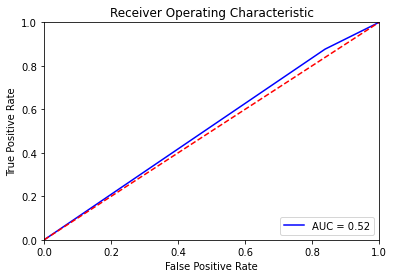



Running sst2 experiment on eda, N10, run# 2


Stopping after epoch 13. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 1.667601247845596e-05

              precision    recall  f1-score   support

           0      0.536     0.156     0.241       912
           1      0.505     0.865     0.638       909

    accuracy                          0.510      1821
   macro avg      0.520     0.510     0.440      1821
weighted avg      0.521     0.510     0.439      1821

Test Set
AUC: 0.5102
Accuracy: 50.9610%


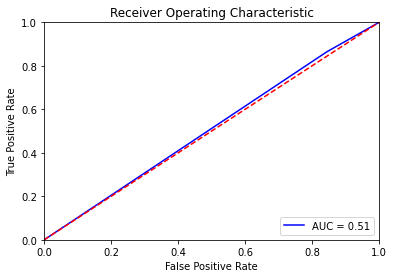



Running sst2 experiment on eda, N10, run# 3


Stopping after epoch 12. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 1.1313960825987124e-06

              precision    recall  f1-score   support

           0      0.000     0.000     0.000       912
           1      0.499     1.000     0.666       909

    accuracy                          0.499      1821
   macro avg      0.250     0.500     0.333      1821
weighted avg      0.249     0.499     0.332      1821

Test Set
AUC: 0.5000
Accuracy: 49.9176%


/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


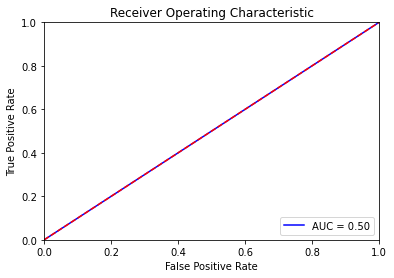

/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/



Running sst2 experiment on eda, N10, run# 4


Stopping after epoch 14. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.0007529792072205055

              precision    recall  f1-score   support

           0      0.500     0.652     0.566       912
           1      0.498     0.345     0.408       909

    accuracy                          0.499      1821
   macro avg      0.499     0.499     0.487      1821
weighted avg      0.499     0.499     0.487      1821

Test Set
AUC: 0.4989
Accuracy: 49.9176%


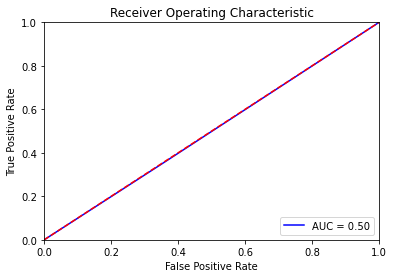



Running sst2 experiment on eda, N10, run# 5


Stopping after epoch 13. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.0021824046998517588

              precision    recall  f1-score   support

           0      0.565     0.014     0.028       912
           1      0.500     0.989     0.664       909

    accuracy                          0.501      1821
   macro avg      0.533     0.502     0.346      1821
weighted avg      0.533     0.501     0.345      1821

Test Set
AUC: 0.5016
Accuracy: 50.0824%


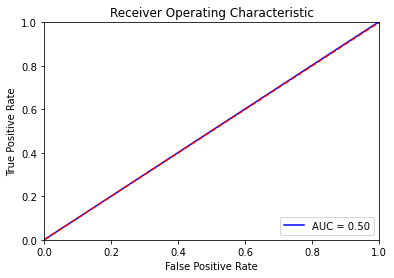



Running sst2 experiment on eda, N10, run# 6


Stopping after epoch 13. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 6.031915029325319e-05

              precision    recall  f1-score   support

           0      0.493     0.669     0.567       912
           1      0.482     0.309     0.377       909

    accuracy                          0.489      1821
   macro avg      0.487     0.489     0.472      1821
weighted avg      0.487     0.489     0.472      1821

Test Set
AUC: 0.4890
Accuracy: 48.9292%


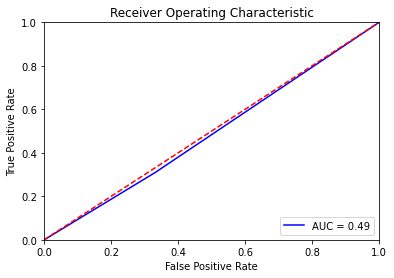

Finished epoch 1 of 1000; error is 3.010772228240967



Running sst2 experiment on eda, N10, run# 7


Stopping after epoch 14. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 3.2318018497790035e-05

              precision    recall  f1-score   support

           0      0.000     0.000     0.000       912
           1      0.499     0.998     0.665       909

    accuracy                          0.498      1821
   macro avg      0.249     0.499     0.332      1821
weighted avg      0.249     0.498     0.332      1821

Test Set
AUC: 0.4989
Accuracy: 49.8078%


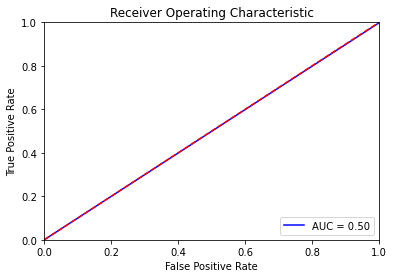



Running sst2 experiment on eda, N10, run# 8


Stopping after epoch 13. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 1.1901304716843697e-05

              precision    recall  f1-score   support

           0      0.505     0.761     0.607       912
           1      0.511     0.251     0.337       909

    accuracy                          0.506      1821
   macro avg      0.508     0.506     0.472      1821
weighted avg      0.508     0.506     0.472      1821

Test Set
AUC: 0.5059
Accuracy: 50.6315%


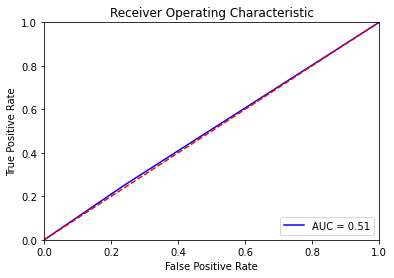



Running sst2 experiment on eda, N10, run# 9


Stopping after epoch 14. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 9.335382564756856e-07

              precision    recall  f1-score   support

           0      0.513     0.328     0.400       912
           1      0.505     0.688     0.582       909

    accuracy                          0.507      1821
   macro avg      0.509     0.508     0.491      1821
weighted avg      0.509     0.507     0.491      1821

Test Set
AUC: 0.5077
Accuracy: 50.7414%


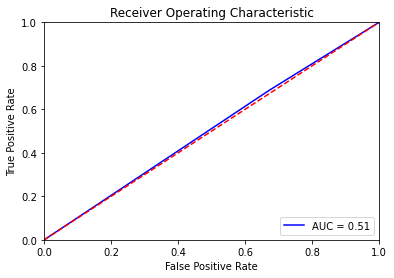



Running sst2 experiment on eda, N10, run# 10


Stopping after epoch 13. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.001247787440661341

              precision    recall  f1-score   support

           0      0.513     0.913     0.657       912
           1      0.601     0.131     0.215       909

    accuracy                          0.523      1821
   macro avg      0.557     0.522     0.436      1821
weighted avg      0.557     0.523     0.436      1821

Test Set
AUC: 0.5221
Accuracy: 52.2790%


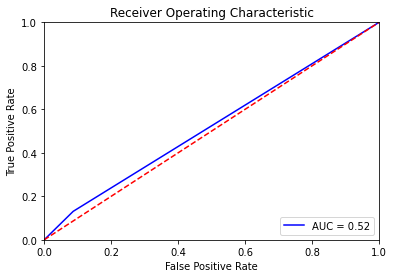



Running sst2 experiment on eda, N10, run# 11


Stopping after epoch 14. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 1.1364600140950643e-06

              precision    recall  f1-score   support

           0      0.533     0.543     0.538       912
           1      0.533     0.524     0.528       909

    accuracy                          0.533      1821
   macro avg      0.533     0.533     0.533      1821
weighted avg      0.533     0.533     0.533      1821

Test Set
AUC: 0.5332
Accuracy: 53.3224%


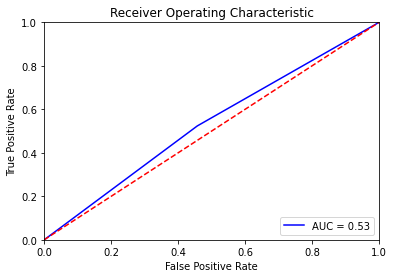



Running sst2 experiment on bt, N10, run# 0


Stopping after epoch 24. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 3.0095042120592552e-06

              precision    recall  f1-score   support

           0      0.410     0.062     0.108       912
           1      0.492     0.910     0.638       909

    accuracy                          0.485      1821
   macro avg      0.451     0.486     0.373      1821
weighted avg      0.451     0.485     0.373      1821

Test Set
AUC: 0.4861
Accuracy: 48.5448%


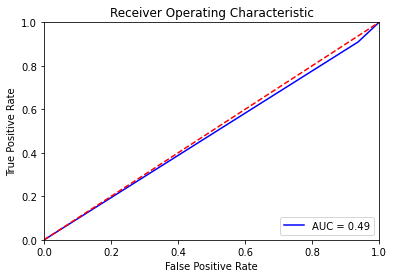



Running sst2 experiment on bt, N10, run# 1


Stopping after epoch 12. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.0874635735526681

              precision    recall  f1-score   support

           0      0.000     0.000     0.000       912
           1      0.499     1.000     0.666       909

    accuracy                          0.499      1821
   macro avg      0.250     0.500     0.333      1821
weighted avg      0.249     0.499     0.332      1821

Test Set
AUC: 0.5000
Accuracy: 49.9176%


/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


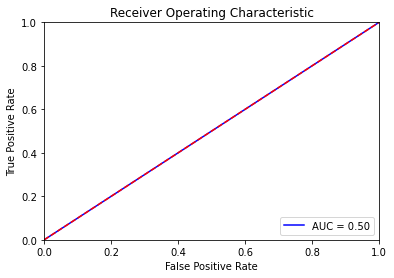

/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/



Running sst2 experiment on bt, N10, run# 2


Stopping after epoch 12. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.003650859751360258

              precision    recall  f1-score   support

           0      0.629     0.024     0.046       912
           1      0.502     0.986     0.665       909

    accuracy                          0.504      1821
   macro avg      0.565     0.505     0.356      1821
weighted avg      0.565     0.504     0.355      1821

Test Set
AUC: 0.5049
Accuracy: 50.4119%


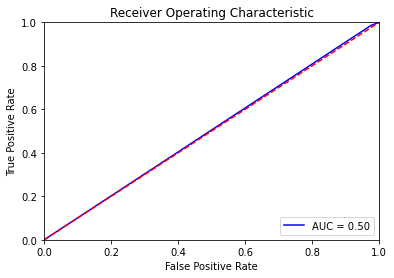

Finished epoch 1 of 1000; error is 1.3275781869888306



Running sst2 experiment on bt, N10, run# 3


Stopping after epoch 12. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.0710807703435421

              precision    recall  f1-score   support

           0      0.000     0.000     0.000       912
           1      0.499     1.000     0.666       909

    accuracy                          0.499      1821
   macro avg      0.250     0.500     0.333      1821
weighted avg      0.249     0.499     0.332      1821

Test Set
AUC: 0.5000
Accuracy: 49.9176%


/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


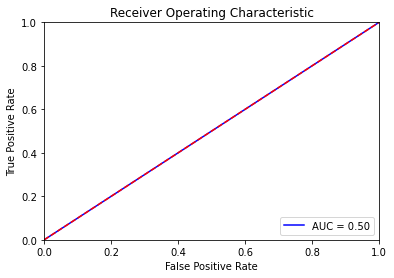

/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/



Running sst2 experiment on bt, N10, run# 4


Stopping after epoch 18. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.3076765388250351

              precision    recall  f1-score   support

           0      0.501     0.963     0.659       912
           1      0.493     0.036     0.068       909

    accuracy                          0.500      1821
   macro avg      0.497     0.500     0.363      1821
weighted avg      0.497     0.500     0.364      1821

Test Set
AUC: 0.4995
Accuracy: 50.0275%


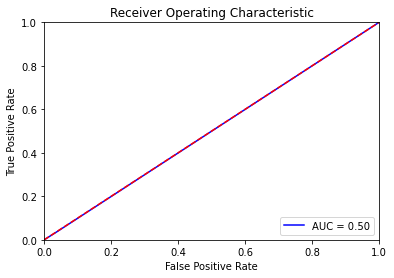



Running sst2 experiment on bt, N10, run# 5


Stopping after epoch 15. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.0009751780889928341

              precision    recall  f1-score   support

           0      0.000     0.000     0.000       912
           1      0.499     1.000     0.666       909

    accuracy                          0.499      1821
   macro avg      0.250     0.500     0.333      1821
weighted avg      0.249     0.499     0.332      1821

Test Set
AUC: 0.5000
Accuracy: 49.9176%


/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


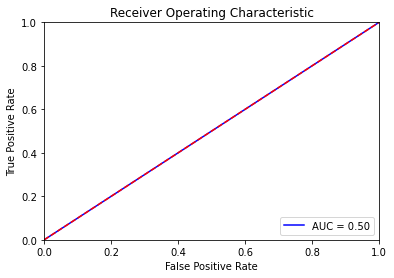

/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/



Running sst2 experiment on bt, N10, run# 6


Stopping after epoch 12. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.13240029755979776

              precision    recall  f1-score   support

           0      0.833     0.005     0.011       912
           1      0.500     0.999     0.667       909

    accuracy                          0.501      1821
   macro avg      0.667     0.502     0.339      1821
weighted avg      0.667     0.501     0.338      1821

Test Set
AUC: 0.5022
Accuracy: 50.1373%


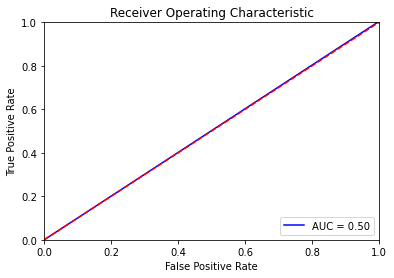

Finished epoch 1 of 1000; error is 1.310340940952301



Running sst2 experiment on bt, N10, run# 7


Stopping after epoch 16. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.1768992613069713

              precision    recall  f1-score   support

           0      0.000     0.000     0.000       912
           1      0.499     0.999     0.665       909

    accuracy                          0.499      1821
   macro avg      0.249     0.499     0.333      1821
weighted avg      0.249     0.499     0.332      1821

Test Set
AUC: 0.4994
Accuracy: 49.8627%


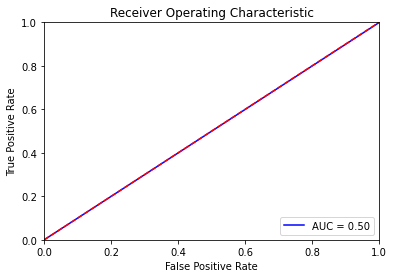



Running sst2 experiment on bt, N10, run# 8


Stopping after epoch 19. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.00012637100371648557

              precision    recall  f1-score   support

           0      0.618     0.037     0.070       912
           1      0.503     0.977     0.664       909

    accuracy                          0.506      1821
   macro avg      0.561     0.507     0.367      1821
weighted avg      0.561     0.506     0.367      1821

Test Set
AUC: 0.5071
Accuracy: 50.6315%


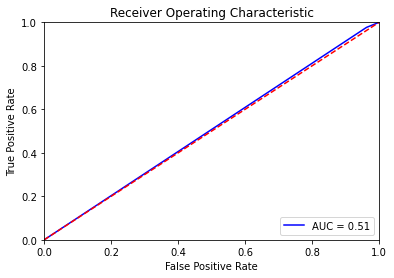

Finished epoch 1 of 1000; error is 1.2885743379592896



Running sst2 experiment on bt, N10, run# 9


Stopping after epoch 17. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 6.454392314481083e-05

              precision    recall  f1-score   support

           0      0.558     0.180     0.272       912
           1      0.510     0.857     0.640       909

    accuracy                          0.518      1821
   macro avg      0.534     0.518     0.456      1821
weighted avg      0.534     0.518     0.455      1821

Test Set
AUC: 0.5184
Accuracy: 51.7847%


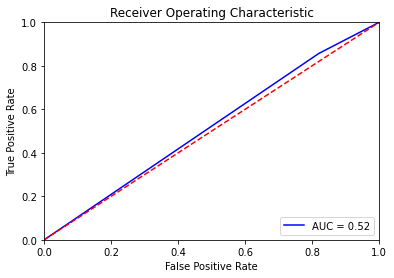



Running sst2 experiment on bt, N10, run# 10


Stopping after epoch 14. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.0029677118873223662

              precision    recall  f1-score   support

           0      0.526     0.488     0.506       912
           1      0.521     0.559     0.539       909

    accuracy                          0.523      1821
   macro avg      0.524     0.523     0.523      1821
weighted avg      0.524     0.523     0.523      1821

Test Set
AUC: 0.5234
Accuracy: 52.3339%


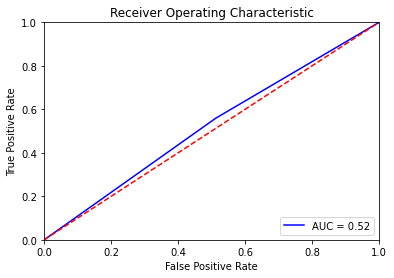

Finished epoch 2 of 1000; error is 1.1900465488433838



Running sst2 experiment on bt, N10, run# 11


Stopping after epoch 20. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.0035172508796676993

              precision    recall  f1-score   support

           0      0.530     0.825     0.645       912
           1      0.602     0.266     0.369       909

    accuracy                          0.546      1821
   macro avg      0.566     0.545     0.507      1821
weighted avg      0.566     0.546     0.507      1821

Test Set
AUC: 0.5454
Accuracy: 54.5854%


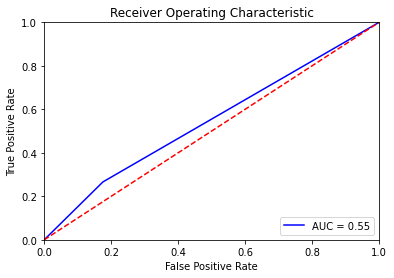

Finished. Please see the experiment metrics report at results/sst2_10_rnn_report.md


In [8]:
RUN_IDS = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
EXPR_TYPES =  ["orig", "para", "para_tc", "para_editdist", "para_tc_editdist", "tc", "tc_editdist", "eda", "bt"]

for expr_type in EXPR_TYPES:
    for run_id in RUN_IDS:
        train_path = get_train_path(expr_type, NUM_SAMPLES, run_id, DATASET_FILENAME, FILE_EXT)
        train = dataset_io.to_df(train_path)
        GLOVE_EMBEDDING, GLOVE_VOCAB = load_glove(train)
        train_labels = normalize_labels(train, LABEL_FIELD)
        print("\n\nRunning {0} experiment on {1}, N{2}, run# {3}".format(
            DATASET_TYPE, expr_type, NUM_SAMPLES, run_id))
        test_preds = run_and_eval(train, TEST, TEXT_FIELD, LABEL_FIELD, _TEST_LABELS, NUM_CLASSES, DATASET_TYPE)
        get_metrics_report(train, TEST, test_preds, _TEST_LABELS, 
                          train_path, TEST_PATH, LABEL_FIELD, 
                          DATASET_TYPE, expr_type, NUM_SAMPLES, run_id, REPORT_RESULTS_PATH)

print("Finished. Please see the experiment metrics report at {0}".format(REPORT_RESULTS_PATH))